In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import matplotlib.dates as mdates

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# Check the names of the tables
Base.classes.keys()

# reflect the tables
# Map the tables to Python classes
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session to interact with the database
session = Session(engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [ ]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

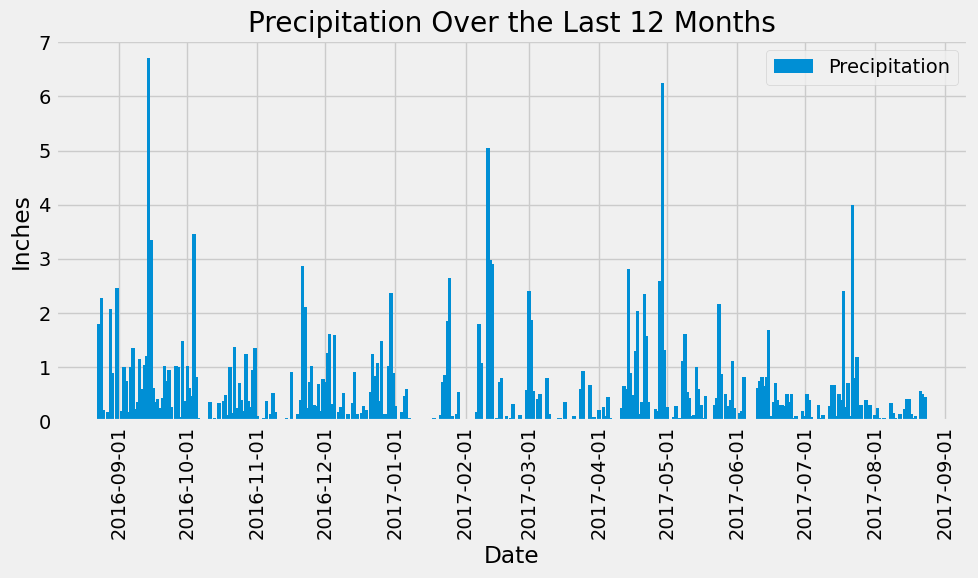

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')).\
    filter(Measurement.prcp != None).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df = df.reset_index()
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df['Date'], df['Precipitation'], width=1.5, label='Precipitation')

# Title and labels
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()

# Format x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df['Precipitation'].describe()
summary_df = pd.DataFrame(summary)
summary_df.columns = ['precipitation']
summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    Measurement.station,
    func.count(Measurement.date) 
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

station_activity_df = pd.DataFrame(active_stations, columns=['Station', 'Observation Count'])
station_activity_df

,Station,Observation Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temp_stats = session.query(
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
    func.max(Measurement.tobs)
).filter(Measurement.station == most_active_station).one()

temp_stats_list = list(temp_stats)

temp_stats_list


[54.0, 71.66378066378067, 85.0]

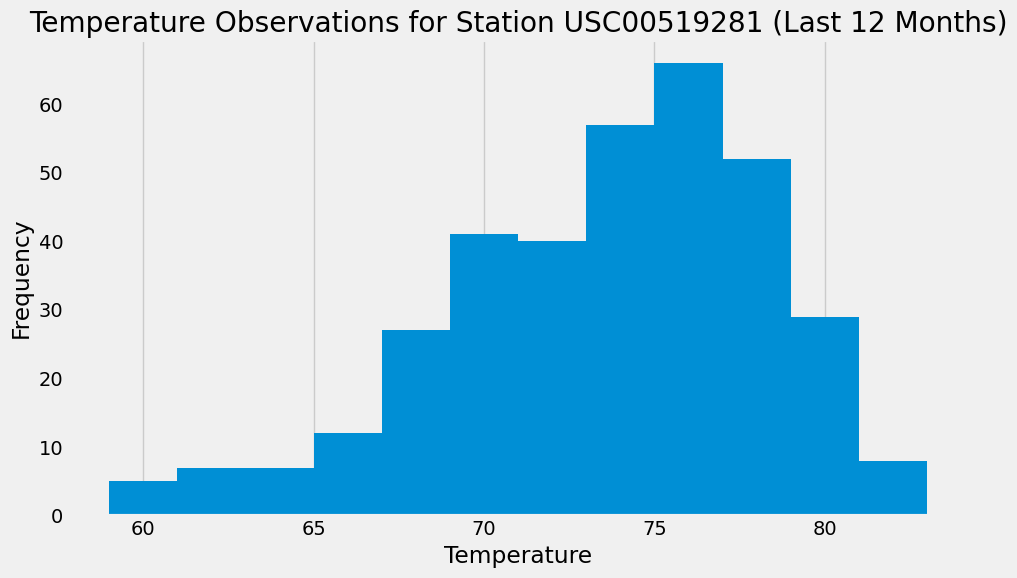

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

tobs_values = [temp[0] for temp in tobs_data]

plt.figure(figsize=(10, 6))
plt.hist(tobs_values, bins=12,label='tobs')

plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Close Session

In [32]:
# Close Session
session.close()